# AASR
from curlander
\begin{equation}
    \text{AASR} \approx \dfrac{\sum_{m\neq 0}{\int_{B_d}{G^2(f + m \text{PRF})\ df}}}{\int_{B_d}{G^2(f)\ df}}
\end{equation}



given a incidence angle (constant)
for an element in the sum
1. find doppler axis
2. find azimuth using mesh_doppler_to_azimuth(theta_mesh, doppler_mesh, lambda_c, v_s, h=500e3, re=6371e3, c=299792458.0)
3. convert azimuth, incidence angle to GCS
4. GCS to LCS
5. LCS to spherical
6. spherical coordinate phi approximated to 0 or pi
7. gain retrieved


In [1]:
import numpy as np
from numpy import sin, cos, arccos, arcsin
from spherical_earth_geometry_radar import *

la = 2
wa = .3
freq = 10e9
c = 299792458.0
lambda_c = c / freq

h = 500e3

incidence_angle = 0.53437381 * 180 / np.pi

looking_angle = incidence_angle_to_looking_angle(incidence_angle * np.pi / 180, h)

PRF = 5096.471786

# processed doppler bandwidth
Bd = 7613.30793042


In [2]:
looking_angle * 180 / np.pi

28.179832174123597

In [3]:
from spherical_earth_geometry_radar import *
from radartools.farField import UniformAperture

uniap = UniformAperture(la, wa, freq)
radGeo = RadarGeometry()
radGeo.set_initial_position(0, 0, h)
radGeo.set_rotation(looking_angle, 0, 0)
v_s = radGeo.orbital_speed()
radGeo.set_speed(v_s)


array([[7612.68398988],
       [   0.        ],
       [   0.        ]])

## step 1: Find doppler extremes


In [4]:
from design_functions import *

# azimuth circle radius
re = 6371e3
r0, rg = range_from_theta(incidence_angle, h)
costheta_e = ((re + h) ** 2 + re ** 2 - r0 ** 2) / (2 * (re + h) * re)

raz = re * costheta_e
d = r0 * cos(looking_angle)
# projected maximum slant range
l = np.sqrt((d + raz) ** 2 - raz ** 2)

# maximum azimuthal angle
costheta_a = (raz ** 2 + (raz + d) ** 2 - l ** 2) / (2 * raz * (raz + d))
theta_a = arccos(costheta_a)
print(180 * theta_a / np.pi)
costheta_a

22.120887205333716


0.9263914165634303

In [5]:
cos_phimax = (-raz ** 2 + (raz + d) ** 2 + l ** 2) / (2 * l * (raz + d))
phimax = arccos(cos_phimax)
print(180 * phimax / np.pi)

67.87911279466628


In [6]:
# then the max doppler shift is:
A = (re + h) ** 2 + re ** 2
B = 2 * (re + h) * re * costheta_e
v = v_s / (re + h)

doppler_max = (B * v * sin(theta_a) / (lambda_c * np.sqrt(A - B * cos(theta_a))))
print(doppler_max)

[467921.59143886]


In [7]:
# this maximum doppler corresponds to a sum order of
n = np.floor(doppler_max / PRF)
n

array([91.])

Doppler axes

In [8]:
dop_ax = np.linspace(-Bd / 2, Bd / 2, 101)
print(dop_ax.shape)

(101,)


given a incidence angle (constant)
for an element in the sum
1. find doppler axis
2. find azimuth using mesh_doppler_to_azimuth(theta_mesh, doppler_mesh, lambda_c, v_s, h=500e3, re=6371e3, c=299792458.0)
3. convert azimuth, incidence angle to GCS
4. GCS to LCS
5. LCS to spherical
6. spherical coordinate phi approximated to 0 or pi
7. gain retrieved

In [9]:

# follow the steps from above
# doppler incidence angle
D, I = np.meshgrid(dop_ax, incidence_angle * np.pi / 180)
print(D.shape)
# Incidence azimuth position stationary slow time
I, A, Tk = mesh_doppler_to_azimuth(I, D, lambda_c, v_s, h)
# gcs coordinate
X, Y, Z = mesh_incidence_azimuth_to_gcs(I, A, lambda_c, v_s, h)
# lcs coordinate
Xl, Yl, Zl = mesh_gcs_to_lcs(X, Y, Z, radGeo.Bc2s, radGeo.S_0)
# lcs spherical coordinates
R, T, P = meshCart2sph(Xl, Yl, Zl)

(1, 101)


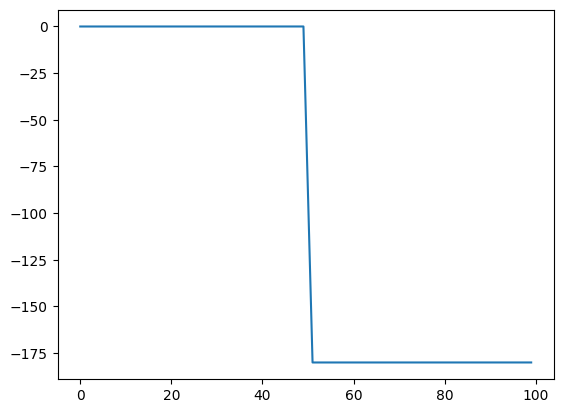

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
ax.plot(P[0][0:100] * 180 / np.pi)

In [11]:
# allign Phi coordinate to closest 0 , 180 value
#print(P)
P = np.round(P / np.pi) * np.pi
P = np.where(P == 0, 2 * np.pi, P)
print(P.shape)
print(T.shape)

(1, 101)
(1, 101)


In [12]:
#Retrieve gain at theta, phi coordinate
G = uniap.mesh_gain_pattern_theor(T, P)
print(G.shape)
G = np.where(np.isnan(G), uniap.max_gain(), G)
G /= uniap.max_gain()
print(G.shape)

(1, 101)
(1, 101)


C:\Users\smen851\PycharmProjects\design-baseline\radartools\farField.py:149: RuntimeWarning: invalid value encountered in divide
  f = sin(kx * self.L / 2) / (kx * self.L / 2) * sin(ky * self.W / 2) / (ky * self.W / 2) * self.L * self.W


(101,)


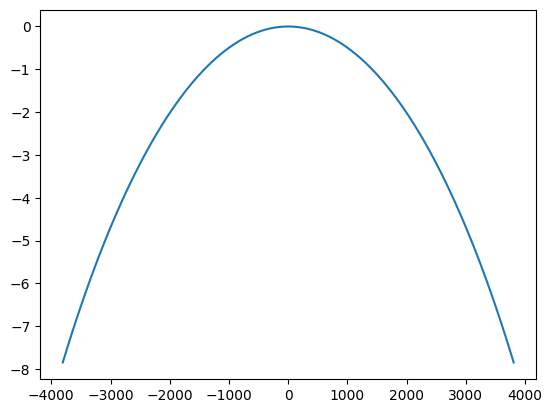

In [13]:
fig, ax = plt.subplots(1)
print(dop_ax.shape)
ax.plot(dop_ax, 10 * np.log10(G[0,:] ** 2))


In [14]:
G[0, :]

array([0.40520691, 0.42150227, 0.43795192, 0.45453684, 0.47123749,
       0.48803384, 0.50490543, 0.52183136, 0.53879036, 0.55576082,
       0.57272084, 0.58964824, 0.60652064, 0.62331547, 0.64001002,
       0.65658151, 0.67300708, 0.6892639 , 0.70532915, 0.72118012,
       0.7367942 , 0.75214898, 0.76722226, 0.7819921 , 0.79643686,
       0.81053526, 0.82426642, 0.83760987, 0.85054565, 0.86305428,
       0.87511687, 0.88671512, 0.89783134, 0.90844855, 0.91855044,
       0.92812147, 0.93714684, 0.94561258, 0.95350555, 0.96081344,
       0.96752487, 0.97362933, 0.97911728, 0.98398008, 0.98821012,
       0.99180072, 0.99474624, 0.99704204, 0.99868449, 0.99967099,
       1.        , 0.99967099, 0.99868449, 0.99704204, 0.99474624,
       0.99180072, 0.98821012, 0.98398008, 0.97911728, 0.97362933,
       0.96752487, 0.96081344, 0.95350555, 0.94561258, 0.93714684,
       0.92812147, 0.91855044, 0.90844855, 0.89783134, 0.88671512,
       0.87511687, 0.86305428, 0.85054565, 0.83760987, 0.82426

In [15]:
# as a function:
# Gain_from_doppler
def gain_from_doppler(doppler_mesh, incidence_mesh, radGeo: RadarGeometry, uniap: UniformAperture, lambda_c, v_s,
                      h=500e3):
    """
    returns the antennna pattern peak approximately close to the doppler point of choice
    :param doppler: doppler axis
    :param incidence: incidence angle of scene center
    :param radGeo: radar Geometry object
    :param uniap: uniform aperture object
    :param v_s: orbital speed
    :param h: platform height
    :return: gain pattern, maximum gain broadside
    """
    # doppler incidence angle
    D, I = doppler_mesh, incidence_mesh
    # Incidence azimuth position stationary slow time
    I, A, Tk = mesh_doppler_to_azimuth(I, D, lambda_c, v_s, h)
    # gcs coordinate
    X, Y, Z = mesh_incidence_azimuth_to_gcs(I, A, lambda_c, v_s, h)
    # lcs coordinate
    Xl, Yl, Zl = mesh_gcs_to_lcs(X, Y, Z, radGeo.Bc2s, radGeo.S_0)
    # lcs spherical coordinates
    R, T, P = meshCart2sph(Xl, Yl, Zl)

    # phi allingnment step
    # allign Phi coordinate to closest 0 , 180 value
    P = np.round(P / np.pi) * np.pi
    P = np.where(P == 0, 2 * np.pi, P)

    G = uniap.mesh_gain_pattern_theor(T, P)
    G = np.where(np.isnan(G), uniap.max_gain(), G)
    maxg = uniap.max_gain()
    return G, maxg



the AASR function can then be implemented as

In [16]:
#from ambiguity_functions import gain_from_doppler

In [17]:
D, I = np.meshgrid(dop_ax, incidence_angle * np.pi / 180)
# 1 denominator
den_g, maxg = gain_from_doppler(D, I, radGeo, uniap, lambda_c, v_s, h)
den_g /= maxg
# integrated denominator
den = integrate.simps(den_g ** 2, D, axis=1)
num = np.zeros_like(den)
den

array([4820.51887593])

In [18]:
from tqdm import tqdm

# 2 numerator sum
for nn in tqdm(range(1, int(n + 1))):
    #D, I = np.meshgrid(dop_ax, incidence_angle * np.pi / 180)
    # positive n
    num_g, maxg = gain_from_doppler(D + float(nn * PRF), I, radGeo, uniap, lambda_c, v_s, h)
    num_g /= maxg
    num += integrate.simps(num_g ** 2, D, axis=1)
    # negative n
    num_g, maxg = gain_from_doppler(D - float(nn * PRF), I, radGeo, uniap, lambda_c, v_s, h)
    num_g /= maxg
    num += integrate.simps(num_g ** 2, D, axis=1)
print(10 * np.log10(num / den))

100%|██████████| 91/91 [00:02<00:00, 34.68it/s]

[-2.58873517]


-1289.81782079
[1317.56022309]
(1, 101)
(101,)


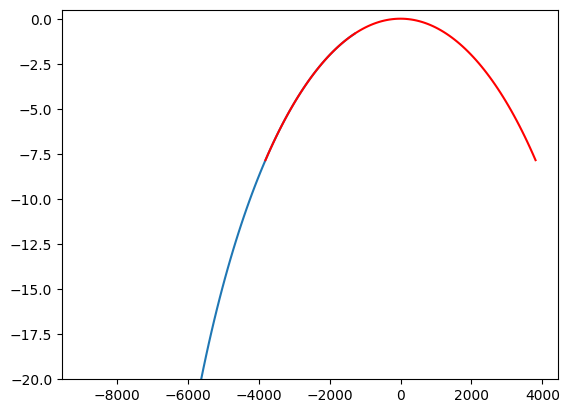

In [19]:
Dj, I = np.meshgrid(dop_ax-PRF, incidence_angle * np.pi / 180)
print(Dj[0,-1])
num_g, maxg = gain_from_doppler(Dj, I, radGeo, uniap, lambda_c, v_s, h)
num_g /= maxg
nn = integrate.simps(num_g ** 2, D, axis=1)
print(nn)
fig, ax = plt.subplots(1)
ax.plot(dop_ax-PRF, 10 * np.log10(num_g[0]**2))
print(num_g.shape)
print(dop_ax.shape)
ax.plot(dop_ax, 10 * np.log10(den_g[0] ** 2),'r')
ax.set_ylim(-20,0.5)
plt.show()

## AASR function

In [20]:
from ambiguity_functions import AASR

aasr = AASR(radGeo, uniap, incidence_angle, PRF, Bd, lambda_c)

[4820.51887593]


100%|██████████| 91/91 [00:02<00:00, 31.39it/s]


In [21]:
print(10 * np.log10(aasr))

[-2.58873517]


In [22]:
incidence_angle

30.61736399532574